# Notes

Readings:
- https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/ - SARIMAX realisation in python
- https://python.quantecon.org/pandas_panel.html - quite intersting guide on Panel Data in Python
- https://www.kaggle.com/code/vipin20/arima-sarimax-exponential-smoothing-using-optuna
- https://galea.medium.com/how-to-love-jsonl-using-json-line-format-in-your-workflow-b6884f65175b
- https://facebook.github.io/prophet/docs/additional_topics.html

- [ ] Using Optuna create SARIMAX model for each and every TS

In [1]:
%pip install optuna --upgrade

Note: you may need to restart the kernel to use updated packages.


# Packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

import sqlite3 as sql

from tqdm.notebook import tqdm

from prophet import Prophet

import warnings

import optuna

print(optuna.__version__)

# Default fig size
plt.rc('figure', figsize=(16,8))

3.2.0


# Read Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv', index_col='id', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv', index_col='id', parse_dates=['date'])

# Quick overlook

In [4]:
train.head()

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [5]:
test.date.nunique()

365

In [6]:
test.head()

,date,country,store,product
id,,,,
136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


For this challenge, you will be predicting a full year worth of sales for various fictitious learning modules from different fictitious Kaggle-branded stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the task of predicting sales during for year 2022.

# Check Dtypes

In reality I looked at .info and then added specification on the first step when read_csv()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27375 entries, 136950 to 164324
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     27375 non-null  datetime64[ns]
 1   country  27375 non-null  object        
 2   store    27375 non-null  object        
 3   product  27375 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.0+ MB


Now look fine.

# Is Data balanced or not ?

I will transform data into panal

In [9]:
panel_train = train.pivot(values=['num_sold'],index=['date'],columns=['country', 'store', 'product'])
test['num_sold'] = pd.NA
panel_test = test.pivot(values=['num_sold'],index=['date'],columns=['country', 'store', 'product'])

The data looks balanced, so we do not create any strategy to fill in the gaps

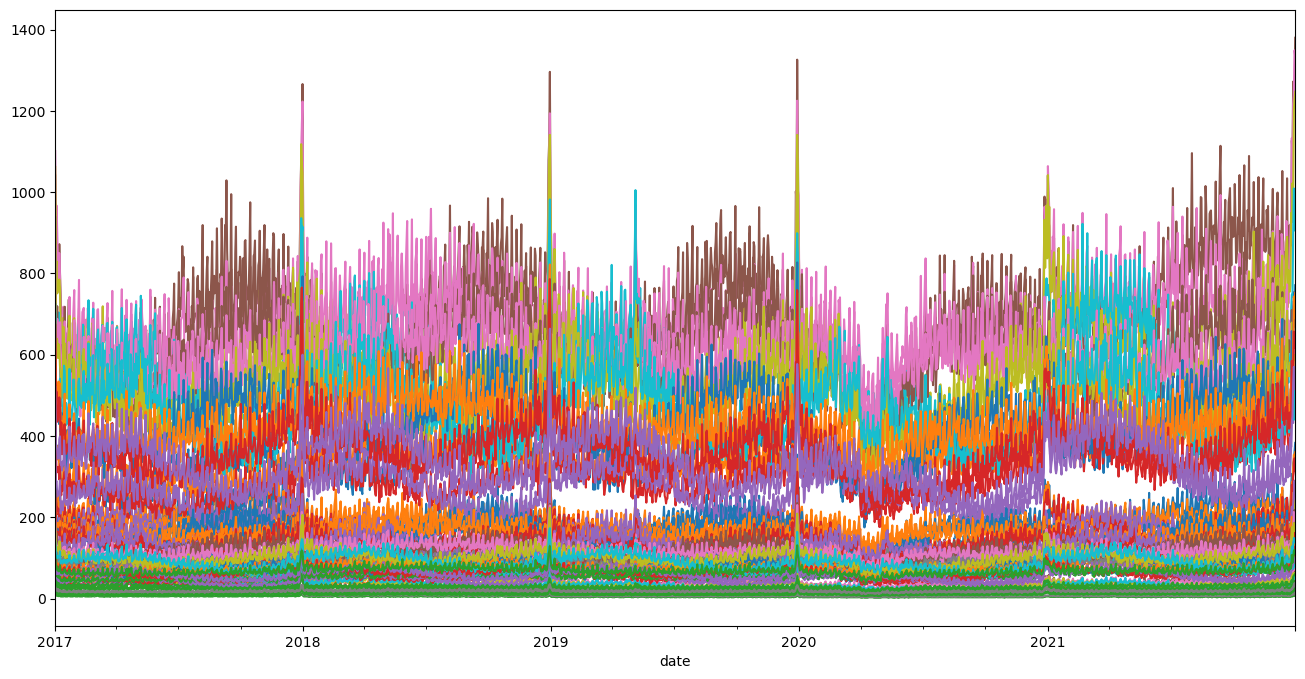

In [10]:
fig, ax = plt.subplots()

panel_train.plot(ax=ax)

ax.legend().set_visible(False)

plt.show()

Looks difference stationary.

So we have even number of products stores and countries

# Go to LogRet

In [11]:
panel_train = panel_train.sort_index()
panel_test = panel_test.sort_index()
panel_train_log_diff  = np.log(panel_train) - np.log(panel_train.shift(1))

panel_log_diff = pd.concat([panel_train_log_diff,panel_test])

In [12]:
panel_log_diff

num_sold                                \
country                            Argentina                                 
store                           Kaggle Learn                                 
product    Using LLMs to Improve Your Coding Using LLMs to Train More LLMs   
date                                                                         
2017-01-01                               NaN                           NaN   
2017-01-02                         -0.211309                     -0.339507   
2017-01-03                         -0.147636                     -0.043485   
2017-01-04                          0.000000                     -0.068993   
2017-01-05                         -0.095310                      0.090972   
...                                      ...                           ...   
2022-12-27                               NaN                           NaN   
2022-12-28                               NaN                           NaN   
2022-12-29                               NaN                           NaN   
2022-12-30                               NaN                           NaN   
2022-12-31                               NaN                           NaN   

                                                           \
country                                                     
store                                                       
product    Using LLMs to Win Friends and Influence People   
date                                                        
2017-01-01                                            NaN   
2017-01-02                                      -0.251314   
2017-01-03                                       0.000000   
2017-01-04                                       0.000000   
2017-01-05                                      -0.154151   
...                                                   ...   
2022-12-27                                            NaN   
2022-12-28                                            NaN   
2022-12-29                                            NaN   
2022-12-30                                            NaN   
2022-12-31                                            NaN   

                                                       \
country                                                 
store                                                   
product    Using LLMs to Win More Kaggle Competitions   
date                                                    
2017-01-01                                        NaN   
2017-01-02                                  -0.316337   
2017-01-03                                  -0.047628   
2017-01-04                                  -0.024693   
2017-01-05                                  -0.025318   
...                                               ...   
2022-12-27                                        NaN   
2022-12-28                                        NaN   
2022-12-29                                        NaN   
2022-12-30                                        NaN   
2022-12-31                                        NaN   

                                                                         \
country                                                                   
store                                                      Kaggle Store   
product    Using LLMs to Write Better Using LLMs to Improve Your Coding   
date                                                                      
2017-01-01                        NaN                               NaN   
2017-01-02                  -0.336472                         -0.173272   
2017-01-03                   0.055570                         -0.145182   
2017-01-04                  -0.145182                          0.117783   
2017-01-05                   0.000000                         -0.087011   
...                               ...                               ...   
2022-12-27                        NaN                               NaN 

# Prophet

In [13]:
import prophet
from prophet.serialize import model_to_json, model_from_json

In [14]:
 warnings.simplefilter(action='ignore',category=FutureWarning)

Idea to Fit each and every TS

In [15]:
for i,index in tqdm(enumerate(panel_log_diff.columns), total=len(panel_log_diff.columns)):

    ts = panel_log_diff[index].dropna()
    ts.name = 'y'
    ts.index.name = 'ds'
    ts = ts.resample('D').sum()
    ts = ts.reset_index()

    # Intialise
    model = Prophet()

    # Fit
    model = model.fit(ts) # Model Will be Overwritten after call

    # Forecast (will have fit & forecast)
    future_dataframe = model.make_future_dataframe(periods=365)
    future_dataframe = model.predict(future_dataframe)

    future_dataframe = future_dataframe[['ds','yhat']].copy()
    future_dataframe = future_dataframe.set_index('ds')['yhat']
    
    
    panel_log_diff.iloc[-365:,i] = future_dataframe.iloc[-365:]
    

  0%|          | 0/75 [00:00<?, ?it/s]

21:32:26 - cmdstanpy - INFO - Chain [1] start processing
21:32:26 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:29 - cmdstanpy - INFO - Chain [1] start processing
21:32:29 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:32 - cmdstanpy - INFO - Chain [1] start processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] done processing
21:32:38 - cmdstanpy - INFO - Chain [1] start processing
21:32:38 - cmdstanpy - INFO - Chain [1]

In [16]:
panel_log_diff

num_sold                                \
country                            Argentina                                 
store                           Kaggle Learn                                 
product    Using LLMs to Improve Your Coding Using LLMs to Train More LLMs   
date                                                                         
2017-01-01                               NaN                           NaN   
2017-01-02                         -0.211309                     -0.339507   
2017-01-03                         -0.147636                     -0.043485   
2017-01-04                          0.000000                     -0.068993   
2017-01-05                         -0.095310                      0.090972   
...                                      ...                           ...   
2022-12-27                         -0.003577                      0.004831   
2022-12-28                          0.003222                      0.002168   
2022-12-29                          0.005865                      0.006401   
2022-12-30                          0.061293                      0.069957   
2022-12-31                          0.037655                      0.037846   

                                                           \
country                                                     
store                                                       
product    Using LLMs to Win Friends and Influence People   
date                                                        
2017-01-01                                            NaN   
2017-01-02                                      -0.251314   
2017-01-03                                       0.000000   
2017-01-04                                       0.000000   
2017-01-05                                      -0.154151   
...                                                   ...   
2022-12-27                                       0.006617   
2022-12-28                                       0.008411   
2022-12-29                                      -0.008915   
2022-12-30                                       0.085824   
2022-12-31                                       0.046938   

                                                       \
country                                                 
store                                                   
product    Using LLMs to Win More Kaggle Competitions   
date                                                    
2017-01-01                                        NaN   
2017-01-02                                  -0.316337   
2017-01-03                                  -0.047628   
2017-01-04                                  -0.024693   
2017-01-05                                  -0.025318   
...                                               ...   
2022-12-27                                   0.002626   
2022-12-28                                   0.002632   
2022-12-29                                   0.004302   
2022-12-30                                   0.072533   
2022-12-31                                   0.036785   

                                                                         \
country                                                                   
store                                                      Kaggle Store   
product    Using LLMs to Write Better Using LLMs to Improve Your Coding   
date                                                                      
2017-01-01                        NaN                               NaN   
2017-01-02                  -0.336472                         -0.173272   
2017-01-03                   0.055570                         -0.145182   
2017-01-04                  -0.145182                          0.117783   
2017-01-05                   0.000000                         -0.087011   
...                               ...                               ...   
2022-12-27                   0.012126                         -0.002987 

# Transform Back

In [17]:
def make_logdiff(a: pd.DataFrame) -> pd.DataFrame:
    b  = np.log(a) - np.log(a.shift(1))
    return b

def make_origin(a: pd.DataFrame, b0 = pd.Series) -> pd.DataFrame:
    b: pd.DataFrame = np.exp(a)
    b.iloc[0] = b0
    for i in tqdm(range(1,len(b.index))):
        b.iloc[i] = b.iloc[i] * b.iloc[i-1]
    return b

panel_train_and_pred = make_origin(a=panel_log_diff, b0=panel_train.iloc[0])

  0%|          | 0/2190 [00:00<?, ?it/s]

In [18]:
panel_train_and_pred

num_sold                                \
country                            Argentina                                 
store                           Kaggle Learn                                 
product    Using LLMs to Improve Your Coding Using LLMs to Train More LLMs   
date                                                                         
2017-01-01                         63.000000                     66.000000   
2017-01-02                         51.000000                     47.000000   
2017-01-03                         44.000000                     45.000000   
2017-01-04                         44.000000                     42.000000   
2017-01-05                         40.000000                     46.000000   
...                                      ...                           ...   
2022-12-27                         69.000684                     90.947759   
2022-12-28                         69.223342                     91.145115   
2022-12-29                         69.630545                     91.730447   
2022-12-30                         74.031923                     98.377446   
2022-12-31                         76.872709                    102.171970   

                                                           \
country                                                     
store                                                       
product    Using LLMs to Win Friends and Influence People   
date                                                        
2017-01-01                                       9.000000   
2017-01-02                                       7.000000   
2017-01-03                                       7.000000   
2017-01-04                                       7.000000   
2017-01-05                                       6.000000   
...                                                   ...   
2022-12-27                                      11.978000   
2022-12-28                                      12.079174   
2022-12-29                                      11.971969   
2022-12-30                                      13.044827   
2022-12-31                                      13.671724   

                                                       \
country                                                 
store                                                   
product    Using LLMs to Win More Kaggle Competitions   
date                                                    
2017-01-01                                  59.000000   
2017-01-02                                  43.000000   
2017-01-03                                  41.000000   
2017-01-04                                  40.000000   
2017-01-05                                  39.000000   
...                                               ...   
2022-12-27                                  73.695361   
2022-12-28                                  73.889567   
2022-12-29                                  74.208116   
2022-12-30                                  79.790661   
2022-12-31                                  82.780421   

                                                                         \
country                                                                   
store                                                      Kaggle Store   
product    Using LLMs to Write Better Using LLMs to Improve Your Coding   
date                                                                      
2017-01-01                  49.000000                         88.000000   
2017-01-02                  35.000000                         74.000000   
2017-01-03                  37.000000                         64.000000   
2017-01-04                  32.000000                         72.000000   
2017-01-05                  32.000000                         66.000000   
...                               ...                               ...   
2022-12-27                  48.084837                         96.526439 

In [19]:
prediction = panel_train_and_pred.unstack().reset_index()

prediction.drop(columns=['level_0'], inplace=True)

prediction = prediction.rename(columns={0:'num_sold'})

prediction

,country,store,product,date,num_sold
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2017-01-01,63.000000
1,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2017-01-02,51.000000
2,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2017-01-03,44.000000
3,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2017-01-04,44.000000
4,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2017-01-05,40.000000
...,...,...,...,...,...
164320,Spain,Kagglazon,Using LLMs to Write Better,2022-12-27,796.212523
164321,Spain,Kagglazon,Using LLMs to Write Better,2022-12-28,806.543416
164322,Spain,Kagglazon,Using LLMs to Write Better,2022-12-29,816.042186
164323,Spain,Kagglazon,Using LLMs to Write Better,2022-12-30,875.315648


In [20]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164325 entries, 0 to 164324
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   country   164325 non-null  object        
 1   store     164325 non-null  object        
 2   product   164325 non-null  object        
 3   date      164325 non-null  datetime64[ns]
 4   num_sold  164325 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 6.3+ MB


In [21]:
test = test.reset_index()

In [22]:
keys = ['date', 'country', 'store', 'product']

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        27375 non-null  int64         
 1   date      27375 non-null  datetime64[ns]
 2   country   27375 non-null  object        
 3   store     27375 non-null  object        
 4   product   27375 non-null  object        
 5   num_sold  0 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.3+ MB


In [24]:
test = test.drop(columns=['num_sold'])

In [25]:
prediction = test.merge(prediction, how='inner',on=keys)

In [26]:
prediction

,id,date,country,store,product,num_sold
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,45.579747
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,48.681165
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,6.269950
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,44.496376
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,32.882916
...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,939.112487
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,1296.784096
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,158.592014
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,832.933714


In [27]:
prediction.to_csv(path_or_buf='submission.csv', index=False, columns=['id','num_sold'])